# Посмотрим, как выглядят примеры для обучения frustum-pointnet

In [1]:
from train.provider import FrustumDataset

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import tqdm
py.init_notebook_mode(connected=True)

EQUAL_ASPECT_RATIO_LAYOUT = dict(
    margin={
        'l': 0,
        'r': 0,
        'b': 0,
        't': 0
    }, scene=dict(
    aspectmode='data'
))


def color(x, cmap='Reds'):
    cmap = plt.get_cmap(cmap)
    x = (x - np.min(x)) / np.max(x)
    
    return cmap(x)

%matplotlib inline

In [27]:
dataset = FrustumDataset(
    npoints=1024,
    rotate_to_center=True,
    split='val',
    overwritten_data_path='../frustum_data/frustum_carpedcyc_val.pickle'
)

In [28]:
example = dataset[100]


layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4, range = [-3,3],),
                    yaxis = dict(
                        nticks=4, range = [-3,3],),
                    zaxis = dict(
                        nticks=4, range = [0, 40],),
                    aspectratio={'x': 1, 'y': 1, 'z': 1}),
                    width=700,
                    margin=dict(
                    r=0, l=0,
                    b=0, t=0)
                  )

fig = go.Figure(layout=layout)


fig.add_scatter3d(**{
    'x': example[0][:, 0],
    'y': example[0][:, 1],
    'z': example[0][:, 2],
    'mode': 'markers',
    'marker': {
        'size': 1,
        'color': color(example[1], 'tab20'),
    },
})

py.iplot(fig)


In [29]:
scene_id = 1
example = dataset[scene_id]


layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4, range = [-3,3],),
                    yaxis = dict(
                        nticks=4, range = [-3,3],),
                    zaxis = dict(
                        nticks=4, range = [0, 40],),
                    aspectratio={'x': 1, 'y': 1, 'z': 6.4}),
                    width=700,
                    margin=dict(
                    r=0, l=0,
                    b=0, t=0),
                  )

fig = go.Figure(layout=layout)


fig.add_scatter3d(**{
    'x': example[0][:, 0],
    'y': example[0][:, 1],
    'z': example[0][:, 2],
    'mode': 'markers',
    'marker': {
        'size': 1,
        'color': color(example[1], 'tab20'),
    },
})


bbox = dataset.get_center_view_box3d(scene_id)
fig.add_mesh3d(
    x=bbox[:, 0],
    y=bbox[:, 1],
    z=bbox[:, 2],
    i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
    j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
    k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
)

py.iplot(fig)


# Получение frustum примеров из сырых данных

In [4]:
from IPython.display import Image

In [6]:
Image(url='http://www.cvlibs.net/datasets/kitti/images/passat_sensors.jpg')

In [253]:
import pickle

In [257]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

In [261]:
xyz = data_example['lidar_xyz']
intensity = data_example['lidar_intensity']
car_to_cam = data_example['car_to_cam']
car_to_lidar = data_example['car_to_lidar']
intrinsic = data_example['intrinsic']
image = data_example['image']

In [262]:
from matplotlib import pyplot as plt

(-60, 60)

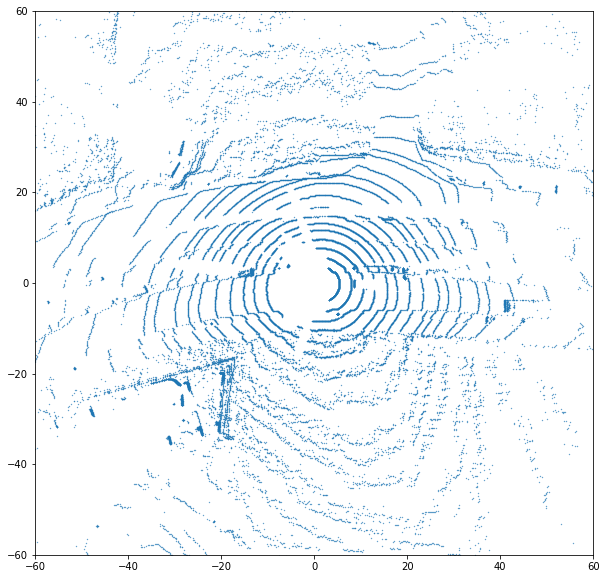

In [263]:
plt.figure(figsize=(10, 10))
plt.scatter(xyz[:, 0], xyz[:, 1], s=0.1)
plt.xlim(-60, 60)
plt.ylim(-60, 60)

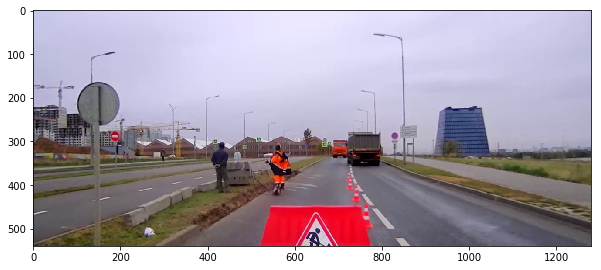

In [265]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [266]:
bbox = np.array(((280, 710), (350, 810)))

In [267]:
def bbox_to_vertices(bbox):
    return np.array([bbox[0], [bbox[0, 0], bbox[1, 1]], bbox[1], [bbox[1, 0], bbox[0, 1]], bbox[0]])

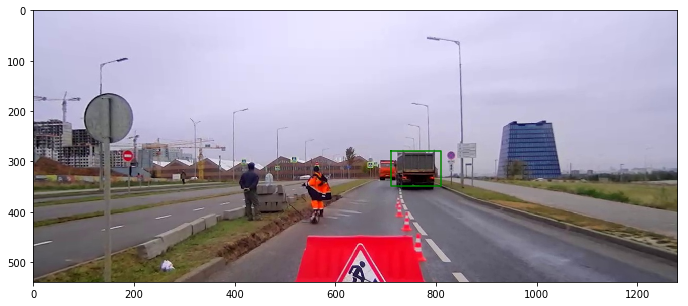

In [268]:
vertices = bbox_to_vertices(bbox)
plt.figure(figsize=(15, 5))
plt.imshow(image)
plt.plot(vertices[:, 1], vertices[:, 0], c='g')

# Что хотим сделать? 

* Спроецируем точки лидара в камеру
* Посмотрим какие точки попали в коробку
* Оставим только эти точки

In [269]:
transform = intrinsic.dot(car_to_cam)

In [270]:
xyz_homogen = np.pad(xyz, ((0, 0), (0, 1)), mode='constant', constant_values=1)

In [271]:
xyw = xyz_homogen.dot(transform.T)

In [272]:
xy_cam = xyw[:, :2] / xyw[:, 2:]

In [273]:
xy_cam_mask = (xy_cam[:, 1] < 540) * (xy_cam[:, 1] > 0) * (xy_cam[:, 0] < 1240) * (xy_cam[:, 0] > 0) * (xyz[:, 0] > 0)

In [274]:
r = np.linalg.norm(xyz[:, :2], axis=1)

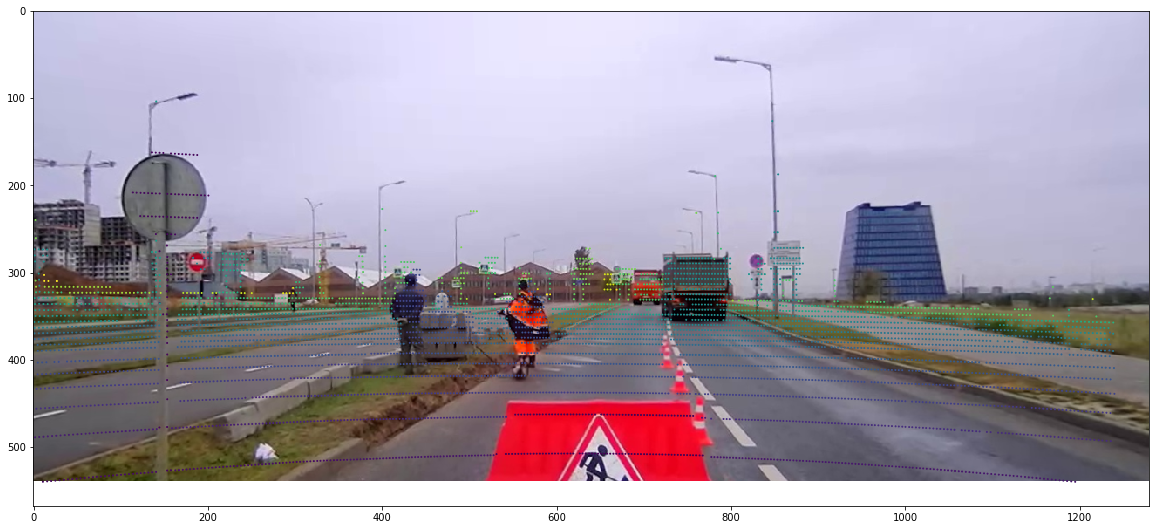

In [275]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.scatter(xy_cam[xy_cam_mask, 0], xy_cam[xy_cam_mask, 1], c=np.log1p(r[xy_cam_mask]), s=1)

In [276]:
xy_cam = xy_cam[xy_cam_mask]

In [277]:
in_box = (xy_cam[:, 1] > bbox[0, 0]) * (xy_cam[:, 1] < bbox[1, 0]) * (xy_cam[:, 0] < bbox[1, 1]) * (xy_cam[:, 0] > bbox[0, 1]) 

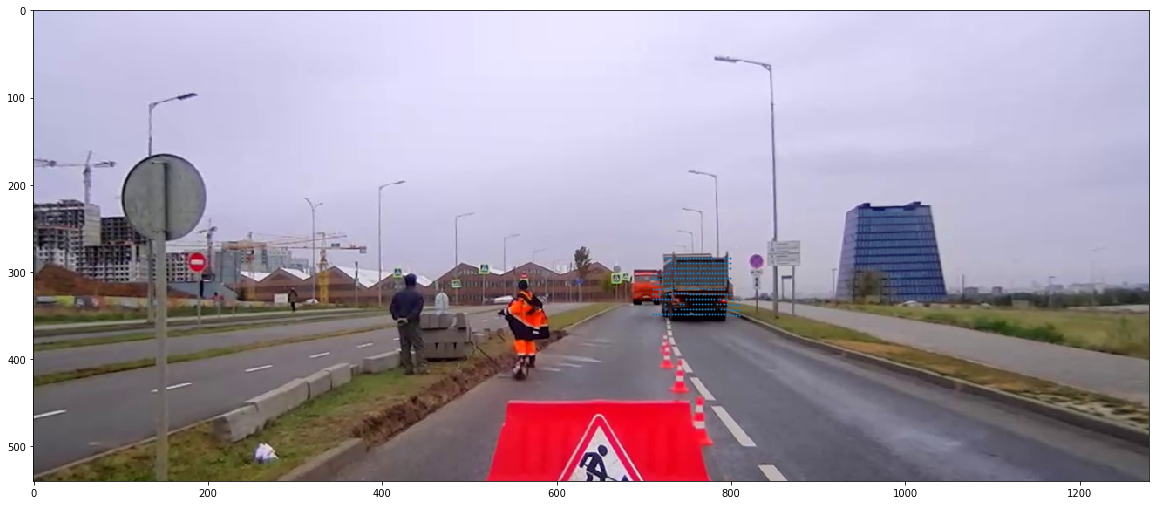

In [278]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.scatter(xy_cam[in_box, 0], xy_cam[in_box, 1], s=1)

In [279]:
xyz_frustum = xyz[xy_cam_mask][in_box]

(-25, 25)

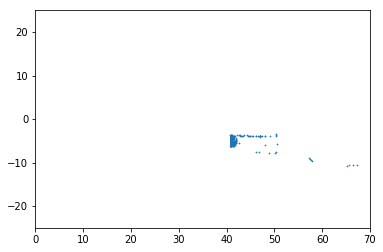

In [280]:
plt.scatter(xyz_frustum[:, 0], xyz_frustum[:, 1], s=0.5)
plt.xlim(0, 70)
plt.ylim(-25, 25)